# Metropolis-adjusted Langevin algorithm Implementations for nonlinear regression with neural network

The Metropolis-adjusted Langevin algorithm (MALA) is a Markov Chain Monte Carlo (MCMC) method for obtaining random samples from a probability distribution for which direct sampling is difficult. MALA uses a combination of two mechanisms to generate the states of a random walk
- New states are proposed using Langevin dynamics: use evaluations of the gradient of the target probability density function
- Proposals are accepted or rejected using Metropolis-Hasting algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Select device which you are going to use for training
device = torch.device("cpu")

## Helper Functions
Helper functions imported from helper files

In [3]:
class Simulator:
    
    def __init__(self, w, b, sigma, N, design_range=(-10,10)):
        self.w = w
        self.b = b
        self.theta = np.expand_dims(np.concatenate([w, [b]], axis=0), axis=1)
        self.sigma = sigma
        self.N = N
        self.design_range = design_range
        self.X = None
        self.y = None
        self.y_mean = None
        
    def run(self):
        designs = np.random.uniform(self.design_range[0], self.design_range[1], size=(self.N, self.w.size))
        self.X = np.concatenate([designs, np.ones((self.N, 1))], axis=1)
        self.y_mean = (self.X @ self.theta).squeeze()
        self.y = np.random.multivariate_normal(mean=self.y_mean, cov=np.diag([self.sigma**2] * self.N))
    
    def plot(self):
        x = self.X[:, 0]
        plt.scatter(x, self.y, label="data")
        x_dense = np.linspace(self.design_range[0], self.design_range[1], 100)
        y_dense = x_dense * self.w[0] + self.b
        plt.plot(x_dense, y_dense, label="y mean")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Simulated data, N="+str(self.N))
        plt.show()

In [4]:
# Helper function for collecting nn gradient into a vector
def collect_grads(model):
    return torch.cat([p.grad.data.view(1, -1) for p in model.parameters()], dim=-1)

# Helper function for computing sizes of all nn parameters
def get_param_sizes(model):
    return [p.reshape(-1).size()[0] for p in model.parameters()]

# Helper function for writing the updated weights
def update_params(new_params, model, param_sizes):
    start_index = 0
    for i, p in enumerate(model.parameters()):
        end_index = start_index + param_sizes[i]
        source_tensor = new_params[:, start_index:end_index].reshape(p.shape)
        p.data = source_tensor
        start_index = end_index

def collect_params(model):
    return torch.cat([p.data.view(1, -1) for p in model.parameters()], dim=-1)

def print_params(model):
    for p in model.parameters():
        print(p.data)

In [5]:
# Helper function for constructing potential energy function
def create_U(X, y, sigma_0):
    
    def U(nn, tau):
        fit = -0.5 * tau * ((y - nn(X)) ** 2).sum()
        params = collect_params(nn)
        l2 = (params ** 2).sum()
        reg = -l2 / (2 * sigma_0 ** 2)
        return fit + reg
    
    return U

# Helper function for constructing gradient of potential energy function
def create_grad_U(X, y, sigma_0):
    
    def grad_U(nn, tau, U):
        PE = U(nn, tau)
        nn.zero_grad()
        PE.backward()
        grad = collect_grads(nn)
        return grad
    
    return grad_U


# Helper function for constructing conditional distribution for tau
def create_p_tau(X, y, alpha_0, beta_0, N):
    alpha = alpha_0 + N / 2
    
    def p_tau(tau, nn):
        z = y - nn(X)
        beta = (beta_0 + 0.5 * z.T @ z).detach().numpy().item()
        return np.random.gamma(alpha, 1 / beta)
    
    return p_tau

In [6]:
# True weight(s)
w = np.array([1.5, -1.0, 0.7])

# Input dimensionality
d = w.size

# True intercept
b = 0.5

# True standard deviation
sigma = 0.5

# Number of data points
N = 100

# Defines range of inputs x
design_range = (-1.0, 1.0)

# Simulate
simulator = Simulator(w, b, sigma, N, design_range)
simulator.run()

X = simulator.X
y = simulator.y

true_params = np.concatenate([[sigma], w, [b]], axis=0)


### Step 1: Implement function that constructs MLP neural network
It would be good to not hardcode the amount of hidden layers, layer dimensions or activation functions but instead make it so that these can be given as arguments to the function.

In [7]:
# True weight(s)
w = np.array([1.5, -1.0, 0.7])

# Input dimensionality
d = w.size

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.layer_1 = nn.Linear(d + 1, 16)
        #self.layer_2 = nn.Linear(16, 16)
        self.output_layer = nn.Linear(16, 1)
    
    def forward(self, x):
        x = torch.sigmoid(self.layer_1(x))
        #x = torch.sigmoid(self.layer_2(x))
        return self.output_layer(x)

In [9]:
# Start with one hidden layer: 2 inputs and 1 output
# Replace log into L2_loss

### Step 2: Evaluate and Sample 
Evaluate log 
$$
log_p(\theta | \alpha^2, D) \propto \frac{-1}{2\alpha^2} (y- f_\theta(x))^T (y - f_\theta(x)) - \frac{-1}{2\alpha_0^2} \theta^T\theta $$

where:
- $log_p(\theta | \alpha^2, D)$ is L2 loss
- $f_\theta(x)$ is the neural network
- $\theta$ is a vector that contains all parameters of the neural network

In [18]:
mlp = MLP()

# Get all the nn parameters and store in theta
theta = torch.cat([x.reshape(-1) for x in mlp.parameters()])

# L2 Loss calculation
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=False).view(1, -1)
l2_loss = ((y_tensor - mlp(X_tensor)) ** 2).sum()

# Define alpha 0
alpha_0 = 0.0001

# Define f0(x)
f0_x = mlp(X_tensor)

#theta


### Step 3: Implement MALA

In [19]:
# p(beta | X, y sigma2)
def LOGPOST(beta, X, y, sigma2, beta0, Sigma2_0):
    log_likelihood = (-0.5 * (y.T - X @ beta) @ (y.T - X @ beta).T / sigma2).squeeze()
    log_prior_beta = (-0.5 * (beta - beta0).reshape(1, -1) @ np.linalg.inv(Sigma2_0) @ (beta - beta0).reshape(-1, 1)).squeeze()
    return log_likelihood + log_prior_beta

#Work in log form for numeric stability
def ACCPT(beta_new, beta_old, x, y, sigma2, beta0, Sigma2_0):
    PN = LOGPOST(beta_new, x, y, sigma2, beta0, Sigma2_0)
    PO = LOGPOST(beta_old, x, y, sigma2, beta0, Sigma2_0)
    logratio = PN - PO
    ratio = np.exp(logratio)
    return min(1, ratio)

In [69]:
# WIP: Implement MALA and get value y
class MALA:
    
    def __init__(self, X, y, mlp):
        # True weight(s)
        self.w = np.array([1.5, -1.0, 0.7])

        # Input dimensionality
        self.d = self.w.size

        # True intercept
        self.b = 0.5
        
        # Preconditioner matrix
        self.no_params = sum(get_param_sizes(mlp))
        self.M = torch.tensor(np.identity(self.no_params)).float()
        
        # Step size for Euler-Maruyama
        self.delta_t = 0.0001
        
        # Standard deviation of weight prior
        self.sigma_0 = 1
        
        # True standard deviation
        self.sigma = 0.5
        
        self.X = X
        self.y = y
        
        self.beta0 = np.zeros(self.d+1)
        self.beta = np.zeros(self.d+1)
        self.sigma2 = np.zeros(self.d+1)
        
        # Shape parameter of noise prior
        self.a0 = 0.001
        
        # Rate parameter of noise prior
        self.b0 = 0.001
        
        # L2 Loss calculation
        self.X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
        self.y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=False).view(1, -1)
        
        # Length of the chain
        self.chain_length = 10000
        
        # Number of discarded samples from beginning
        self.burn_in = 0
        
        # Number of data points
        self.N = 100
        
        self.Sigma2_0 = self.sigma_0 ** 2 * np.identity(self.d+1)
        
    
    def step(self, beta_old, sigma2, mlp, param_sizes):
        mlp.zero_grad()
        
        l2_0 = - (((self.y_tensor.T - mlp(self.X_tensor)) ** 2) / 2*sigma2).sum()
        params = collect_params(mlp)
        l2 = (params ** 2).sum()
        reg = l2 / (2 * sigma_0 ** 2)
        l2_loss = l2_0 - reg
        
        #print("mlp sensor", mlp(self.X_tensor))
        #print("y - x", self.y_tensor.T - mlp(self.X_tensor) )
        
        l2_loss.backward()
        
        with torch.no_grad():
            grad = collect_grads(mlp)
            #print("Gradient", grad)

            proposal_mean = torch.squeeze(beta_old.T + 0.5 * self.delta_t * self.M @ grad.T )
            proposal_cov = self.M * self.delta_t

            beta_proposed = np.random.multivariate_normal(mean=proposal_mean, cov=proposal_cov)
            beta_proposed = torch.tensor(beta_proposed, dtype=torch.float32, requires_grad=False).view(1,-1)
   
            # Write proposed parameters into neural network
            update_params(beta_proposed, mlp, param_sizes)

            u = np.random.uniform()
        
        return beta_proposed, 1
        
    
    
    def run(self, model, param_sizes, theta, tau):
        
        num_samples = self.chain_length - self.burn_in
        self.samples = np.zeros((num_samples, self.no_params + 1))
        acceptances = []
        
        # Initialize chain
        
        for i in range(self.chain_length):
            theta, acceptance = self.step(theta, 1/tau, model, param_sizes)
            #print(theta, acceptance)
            
            with torch.no_grad():
                update_params(theta, model, param_sizes)
                tau = p_tau(tau, model)
                #print(tau)
    
            if i >= self.burn_in:
                j = i - self.burn_in
                self.samples[j, 0] = np.sqrt(1/tau)
                self.samples[j, 1:] = theta.detach().numpy().squeeze()
                acceptances.append(acceptance)
                #print(acceptance)
                
        acceptance_rate = np.array(acceptances).mean()
        
        return self.samples, acceptance_rate
    
    
    def plot(self):
        
        true_params = np.concatenate([[self.sigma], self.w, [self.b]], axis=0)
        
        num_params = self.d + 2
        plt.figure(figsize=(15, 5 * num_params))
        param_names = ["sigma"]
        
        for i in range(num_params - 2):
            param_names.append("weight " + str(i+1))
        param_names.append("intercept")
        
        for i in range(num_params):
            true_val = true_params[i]
            samples = self.samples[:, i]
            plt.subplot(num_params,2,i*2+1)
            y, _, _ = plt.hist(samples, bins=100, label="samples")
            max_y = int(np.max(y))
            plt.plot([true_val] * max_y, range(max_y), c="r", label="true value")
            plt.title("Histogram for {}".format(param_names[i]))
            plt.legend()
            plt.subplot(num_params,2,i*2+2)
            plt.plot(samples, label="chain")
            plt.plot([0, samples.size], [true_val, true_val], c="r", label="true value")
            plt.title("Trace plot for {}".format(param_names[i]))
            plt.legend()
            
        plt.show()

In [70]:
# Define priors
sigma_0 = 1.0
alpha_0 = 0.001
beta_0 = 0.001

# Create helper functions
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=False).view(-1, 1)
U = create_U(X_tensor, y_tensor, sigma_0=sigma_0)
grad_U = create_grad_U(X_tensor, y_tensor, sigma_0=sigma_0)
p_tau = create_p_tau(X_tensor, y_tensor, alpha_0, beta_0, N)

mlp = MLP()
param_sizes = get_param_sizes(mlp)
num_params = sum(param_sizes)

# Define HMC parameters

# Step size
epsilon = 0.01

# Number of steps in the proposal
L = 20

# Mass parameter
m = 1.0

chain = MALA(X, y, mlp)

# Initialize chain
theta = collect_params(mlp)
tau = 1.0

# Run chain
samples, acceptances = chain.run(mlp, param_sizes, theta, tau)

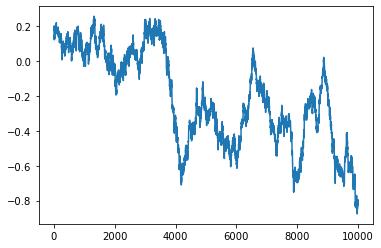

In [71]:
plt.plot(samples[:, 5])
plt.show()

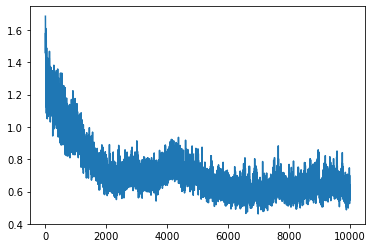

In [72]:
plt.plot(samples[:, 0])
plt.show()

In [73]:
mean_weights = samples[:, 1:].mean(axis=0).reshape(1, -1)
mean_weights_tensor = torch.tensor(mean_weights, dtype=torch.float32)
update_params(mean_weights_tensor, mlp, param_sizes)
y_pred = mlp(X_tensor)
mse = ((y_pred - y_tensor) ** 2).mean()
mse

tensor(0.4183, grad_fn=<MeanBackward0>)

In [74]:
mse2 = ((y_pred.T - torch.tensor(simulator.y_mean).T) ** 2).mean()
mse2

tensor(0.1512, dtype=torch.float64, grad_fn=<MeanBackward0>)

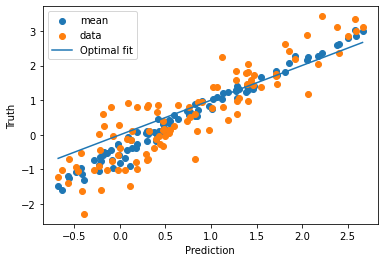

In [75]:
y_pred = y_pred.detach().numpy()
plt.scatter(y_pred, simulator.y_mean, label="mean")
plt.scatter(y_pred, y, label="data")
grid = np.linspace(np.min(y_pred), np.max(y_pred), 100)
plt.plot(grid, grid, label="Optimal fit")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.legend()
plt.show()